# Implement with Random Forest

In [ ]:
!pip install -q zarr gcsfs fsspec
!pip install -q xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import zarr
import fsspec
import warnings

## Data Preprocessing

In [ ]:
#Helper functions
def open_agcd_engine_zarr(store):
    try: return xr.open_dataset(store, engine="zarr", chunks={})
    except Exception: return xr.open_zarr(store, consolidated=True, chunks={})

def subset_years(ds, start, end):
    keep = VARS_X + [TARGET]
    ds = ds[keep].sel(**REGION).sel(time=slice(start, end))
    return ds.astype("float32")

def add_lat_lon_features(ds):
    """Adds latitude and longitude as features (variables)"""
    lon_grid, lat_grid = np.meshgrid(ds.lon, ds.lat)
    ds = ds.assign(
        lat_feat=(("lat", "lon"), lat_grid),
        lon_feat=(("lat", "lon"), lon_grid)
    )
    return ds

In [ ]:
# Data source and parameters
STORE_URL = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/AGDC-feedstock/AGCD.zarr'
TARGET = 'precip'
VARS_X = ['tmax', 'tmin', 'vapourpres'] # 'precip' is the target
REGION = dict(lat=slice(-44.5, -10), lon=slice(112, 156.5))

# Add 'lat' and 'lon' as features. 'doy' features are removed.
VARS_FOR_MODEL = VARS_X + ['lat_feat', 'lon_feat']
C_IN = len(VARS_FOR_MODEL)

TRAIN_YEARS = ('1971', '2000') # 30 years
TEST_YEARS  = ('2011', '2019') # 9 years

ds_all = open_agcd_engine_zarr(STORE_URL)
ds_tr = subset_years(ds_all, *TRAIN_YEARS)
ds_te = subset_years(ds_all, *TEST_YEARS)

# Resample daily data to *YEARLY* averages and load into memory
# '1Y' means 1-Year frequency
ds_train_yearly = ds_tr.resample(time='1Y').mean().load()
ds_test_yearly = ds_te.resample(time='1Y').mean().load()

# Add lat/lon features
ds_train_yearly = add_lat_lon_features(ds_train_yearly)
ds_test_yearly = add_lat_lon_features(ds_test_yearly)

# Flattening (time, lat, lon) datasets to 2D DataFrames
# This "flattens" the data so each row is one pixel at one *year*
df_train = ds_train_yearly.to_dataframe().dropna()
df_test = ds_test_yearly.to_dataframe().dropna()

print(f"Total training samples (pixels * years): {len(df_train)}")

# y is the dependent variable. it is just the 'precip' column
y_train = df_train.pop(TARGET).values
y_test = df_test.pop(TARGET).values

# X is the df of all dependent variables
X_train = df_train[VARS_FOR_MODEL].values
X_test = df_test[VARS_FOR_MODEL].values


#saving data to local directory
np.savez_compressed(
    "agcd_yearly_train_test.npz",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)

print("Saved to yearly_train_test_data.npz")

# Use the code below when loading data from local
data = np.load("agcd_yearly_train_test.npz")
X_train = data["X_train"]
y_train = data["y_train"]
X_test  = data["X_test"]
y_test  = data["y_test"]

/usr/local/lib/python3.12/dist-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/usr/local/lib/python3.12/dist-packages/xarray/groupers.py:530: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


Total training samples (pixels * years): 18366780


## Training Random Forest Model

In [ ]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,      # Use all CPU cores
    max_depth=10,     # Prevent overfitting
    min_samples_leaf=10
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_jobs=-1,
                      random_state=42)

## Model Evaluation

Final Pixel-by-Pixel Test RMSE: 0.6851


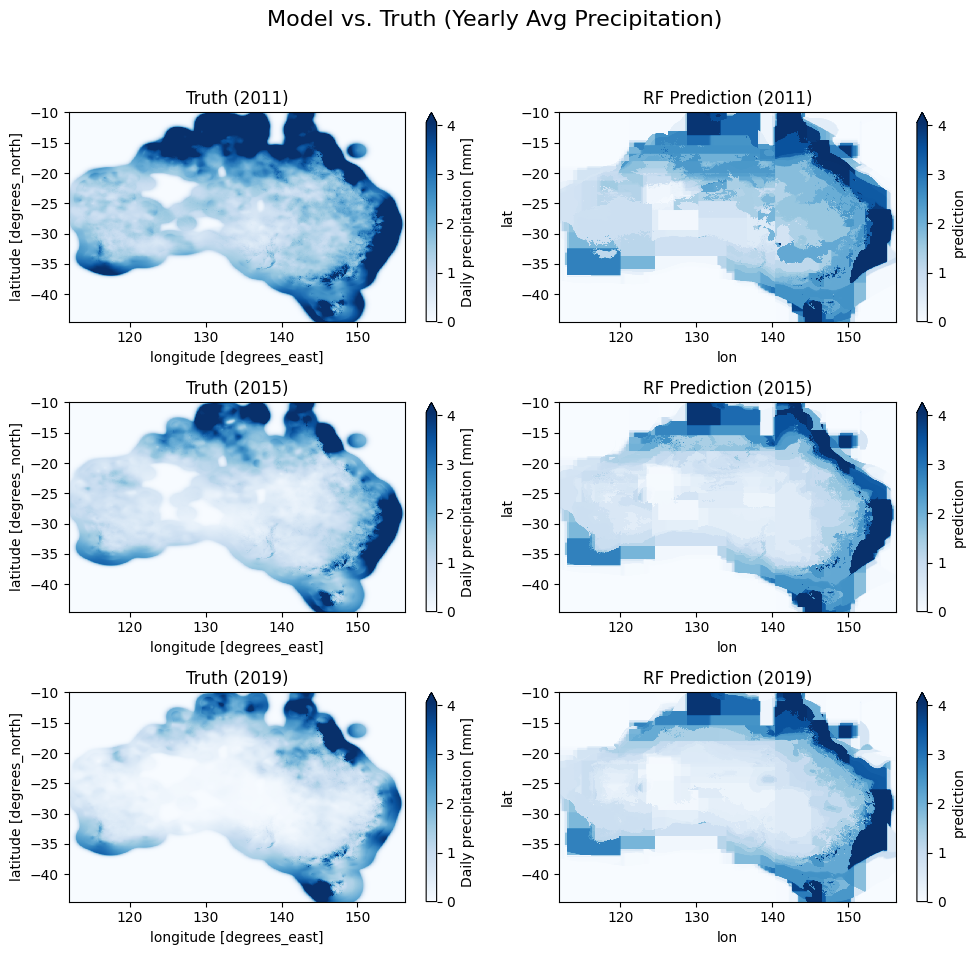

In [ ]:
# Get predictions on the test set
# 'X_test' and 'y_test' still exist in memory from Cell 4
pred_test = model.predict(X_test)

# Calculate RMSE on the raw (flattened) data
test_rmse = np.sqrt(mean_squared_error(y_test, pred_test))
print(f"Final Pixel-by-Pixel Test RMSE: {test_rmse:.4f}")

# We create a new pandas Series using our predictions and that index
pred_series = pd.Series(pred_test, index=df_test.index, name="prediction")

# Now, convert that pandas Series directly to an xarray DataArray
# xarray will automatically re-create the (time, lat, lon) dimensions
pred_map = pred_series.to_xarray()

# 'ds_test_yearly' also still exists in memory
# The truth_map is just the precip variable from it
truth_map = ds_test_yearly[TARGET]

# Plot all 9 years of the test set (or fewer if you like)
sample_years = [0, 4, 8] # Plot 2011, 2015, 2019
vmax = truth_map.quantile(0.95) # Get 95th percentile for colorbar

fig, axes = plt.subplots(nrows=len(sample_years), ncols=2, figsize=(10, 10))
fig.suptitle("Model vs. Truth (Yearly Avg Precipitation)", fontsize=16)

for i, year_index in enumerate(sample_years):
    ax_truth, ax_pred = axes[i, 0], axes[i, 1]

    # Get the time label for the title
    time_label = pd.to_datetime(truth_map.time[year_index].values).strftime('%Y')

    # Plot Truth
    truth_map.isel(time=year_index).plot(ax=ax_truth, vmin=0, vmax=vmax, cmap='Blues')
    ax_truth.set_title(f"Truth ({time_label})")

    # Plot Prediction
    pred_map.isel(time=year_index).plot(ax=ax_pred, vmin=0, vmax=vmax, cmap='Blues')
    ax_pred.set_title(f"RF Prediction ({time_label})")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()